# Franka Panda Robot Control with Simulation

This notebook demonstrates clean robot control using the `RobotExecutor` for both simulation and real robot execution.

**Key Features:**
- Clean separation between simulation and real robot execution
- Target approach (move to grasp pose)  
- Velocity following (manipulation tasks)
- Safe credential handling

In [90]:
# Imports and setup
%load_ext autoreload
%autoreload 2

import os
import time
import getpass
import logging
import numpy as np
import matplotlib.pyplot as plt
import spatialmath as sm
import spatialgeometry as sg

# pandaSim imports
from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter
from pandaSim.geometry.utils import create_virtual_panda
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner
from pandaSim.control import QPController, RobotExecutor, ExecutionConfig

# Real robot imports
import panda_py
from panda_py import controllers

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Robot Connection Setup

Secure credential loading and robot connection initialization.


In [ ]:
# Load credentials safely
try:
    import dotenv
    dotenv.load_dotenv('../.env')  # Load from .env file
except ImportError:
    pass  # python-dotenv not installed, use environment variables

hostname = os.getenv("PANDA_HOST") or input("Panda hostname/IP: ").strip()
username = os.getenv("PANDA_USER") or input("Desk Username: ").strip() 
password = os.getenv("PANDA_PASS") or getpass.getpass("Desk Password: ")

print(f"Connecting to {hostname} as {username}")

# Connect to desk and real robot
desk = panda_py.Desk(hostname, username, password, platform='panda')
unlocked = desk.unlock()

time.sleep(3)


Connecting to 172.16.0.2 as Kao


INFO:desk:Login succesful.
INFO:desk:Retaken control.
INFO:panda:Connected to robot (172.16.0.2).
INFO:panda:Panda class destructor invoked (172.16.0.2).
INFO:panda:Stopping active controller (Integrated Velocity).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 3.92 seconds.
INFO:panda:Starting new controller (JointTrajectory).
ERROR:panda:Control loop interruped: libfranka: Move command aborted: motion aborted by reflex! ["communication_constraints_violation"]
control_command_success_rate: 0.66


Robot reached starting position:  False


In [97]:

panda_real = panda_py.Panda(hostname)
reached = panda_real.move_to_start()

print("Robot reached starting position: ", reached)

INFO:panda:Connected to robot (172.16.0.2).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.08 seconds.
INFO:panda:Starting new controller (JointTrajectory).


Robot reached starting position:  True


In [93]:
# Create simulation environment
adapter = RoboticsToolboxAdapter({
    "realtime": True,
    "rate": 100,
    "browser": "google-chrome"  # or "notebook" for visualizing in jupyter notebook
})

# Create virtual robot
urdf_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda_sim = create_virtual_panda(urdf_path=urdf_path)

n = 7  # arm DOF

# Sync simulation with real robot
panda_sim.q[:n] = panda_real.q[:n]

# Add robot to environment
env = adapter.env
env.add(panda_sim)

# Open gripper
if hasattr(panda_sim, 'grippers') and panda_sim.grippers:
    panda_sim.grippers[0].q = [0.035, 0.035]

print(f"Simulation setup complete. Rate: {adapter.env.rate} Hz")


INFO:websockets.server:server listening on 127.0.0.1:53002


INFO:websockets.server:connection open


Simulation setup complete. Rate: 100 Hz


## Scene and Planning Setup

Create objects and compute grasp pose using the screw motion planner.


In [94]:
# Create scene objects
box = sg.Box(
    scale=[0.2, 0.07, 0.1], 
    color='blue', 
    pose=sm.SE3(0.7, 0.0, 0.05)
)

# Visualization axes
ee_axes = sg.Axes(0.15)  # End-effector pose
goal_axes = sg.Axes(0.1)  # Target grasp pose

# Add to environment
env.add(ee_axes)
env.add(goal_axes)
env.add(box)

# Update end-effector visualization
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')

# Compute grasp pose
planner = ScrewMotionPlanner(adapter=adapter)

grasp_pose, qs, s_axes = planner.compute_grasp(
    obj=box,
    adapter=adapter,
    grasp_height="top",
    prefer_closer_grasp=True,
    gripper_offset=sm.SE3.Rx(np.pi/2).A,
    output_type="t"
)

# Update goal visualization
goal_axes.T = grasp_pose

# For object manipulation: compute relative transform
wTg = grasp_pose  # grasp pose in world
wTb = box.T       # box pose in world
gTb = np.linalg.inv(wTg) @ wTb  # box pose in grasp 
adapter.step_simulation(adapter.dt)

print(f"Grasp pose computed. Distance to target: {np.linalg.norm(grasp_pose[:3, 3] - panda_sim.fkine(panda_sim.q).t):.3f}m")


Grasp pose computed. Distance to target: 0.605m


## Controller and Executor Setup

Initialize the QP controller and robot executor with clean configuration.


In [108]:
# Create QP controller
controller = QPController(
    adapter=adapter,
    robot=panda_sim,
    end_effector_link='panda_finger_virtual',
    gains_translation=2.0,
    gains_rotation=1.0,
    threshold=0.001,
    lambda_q=0.05,
    lambda_m=1.0,
    lambda_j=0.1,
    ps=0.5,
    pi=0.3,
    eta=1.0,
    solver="quadprog",
    T=7.0,
)

# Execution configuration (controller-focused parameters only)
config = ExecutionConfig(
    frequency=100.0,
    max_runtime=20.0,
    convergence_threshold=0.005,
    safety_timeout=30.0
)

# Create robot executor
executor = RobotExecutor(controller, adapter, config)

print("Controller and executor ready")


Controller and executor ready


## Case 1: Target Approach - Simulation Only

Move robot to grasp pose using simulation for testing and visualization.


INFO:pandaSim.control.robot_executor:Starting simulation approach to target


Starting simulation approach to grasp pose...


INFO:pandaSim.control.robot_executor:Simulation completed: arrived=True, steps=952



Simulation Results:
  Converged: True
  Steps: 952
  Execution time: 9.51s


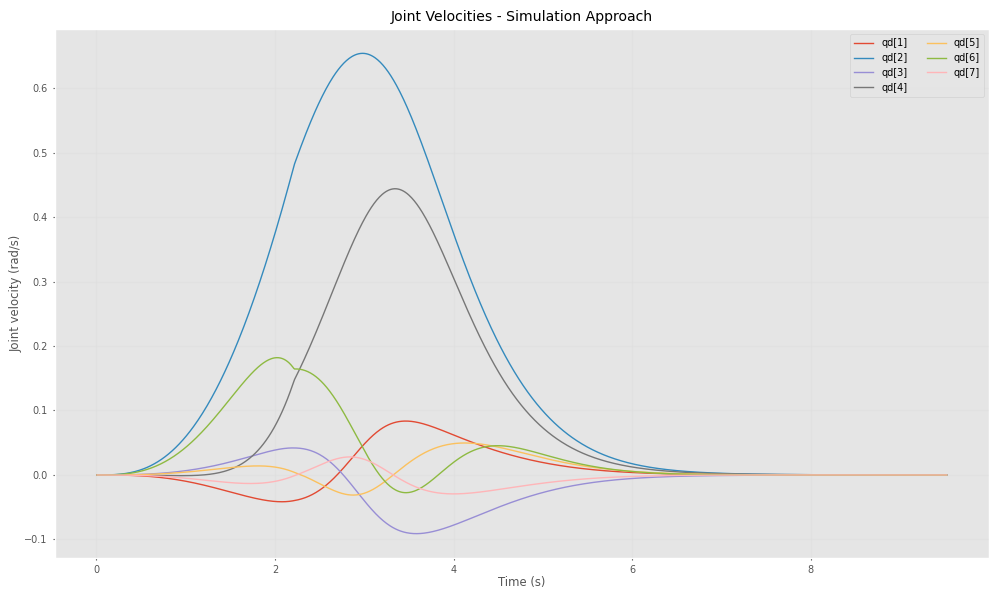

In [112]:
# Execute approach in simulation
print("Starting simulation approach to grasp pose...")

panda_sim.q[:7] = panda_real.q[:7]

result_sim = executor.approach_target(
    target_pose=grasp_pose,
    sim_robot=panda_sim,
    optimization_type="j",  # joint limit optimization
    use_real_robot=False
)

# Results
print(f"\nSimulation Results:")
print(f"  Converged: {result_sim.converged}")
print(f"  Steps: {result_sim.n_steps}")
print(f"  Execution time: {result_sim.execution_time:.2f}s")


# Update visualization
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
adapter.step_simulation(adapter.dt)

# Plot trajectory
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(min(7, result_sim.joint_velocities.shape[1])):
    ax.plot(result_sim.time_history, result_sim.joint_velocities[:, i], 
            label=f'qd[{i+1}]', linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint velocity (rad/s)')
ax.set_title('Joint Velocities - Simulation Approach')
ax.legend(ncol=2)
# ax.set_ylim(-3, 3)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save simulation data
# result_sim.save("approach_simulation.npz")
# print("Simulation data saved to 'approach_simulation.npz'")


## Case 1: Target Approach - Real Robot

Execute the same approach on the real robot after simulation validation.


In [115]:
# Reset robot to starting position
panda_real.move_to_start()
panda_sim.q[:n] = panda_real.q[:n]
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
adapter.step_simulation(adapter.dt)
time.sleep(3)


INFO:panda:Stopping active controller (Integrated Velocity).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 3.93 seconds.
INFO:panda:Starting new controller (JointTrajectory).


In [113]:

# Execute approach on real robot
print("Starting real robot approach to grasp pose...")
print("⚠️  Real robot will move - ensure workspace is clear!")

result_real = executor.approach_target(
    target_pose=grasp_pose,
    sim_robot=panda_sim,
    real_robot=panda_real,
    optimization_type="j",
    use_real_robot=True  # 🔴 REAL ROBOT EXECUTION
)

# Results
print(f"\nReal Robot Results:")
print(f"  Converged: {result_real.converged}")
print(f"  Steps: {result_real.n_steps}")
print(f"  Execution time: {result_real.execution_time:.2f}s")

# # Save real robot data
# result_real.save("approach_real.npz")
# print("Real robot data saved to 'approach_real.npz'")


INFO:pandaSim.control.robot_executor:Starting real robot approach to target
INFO:panda:Stopping active controller (JointTrajectory).
INFO:panda:Starting new controller (Integrated Velocity).


Starting real robot approach to grasp pose...
⚠️  Real robot will move - ensure workspace is clear!


INFO:panda:Stopping active controller (Integrated Velocity).
INFO:pandaSim.control.robot_executor:Average optimization time per step: 0.001867 seconds
INFO:pandaSim.control.robot_executor:Real robot execution completed: arrived=True



Real Robot Results:
  Converged: True
  Steps: 1310
  Execution time: 13.21s


/tmp/ipykernel_7451/759055365.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncol=2)


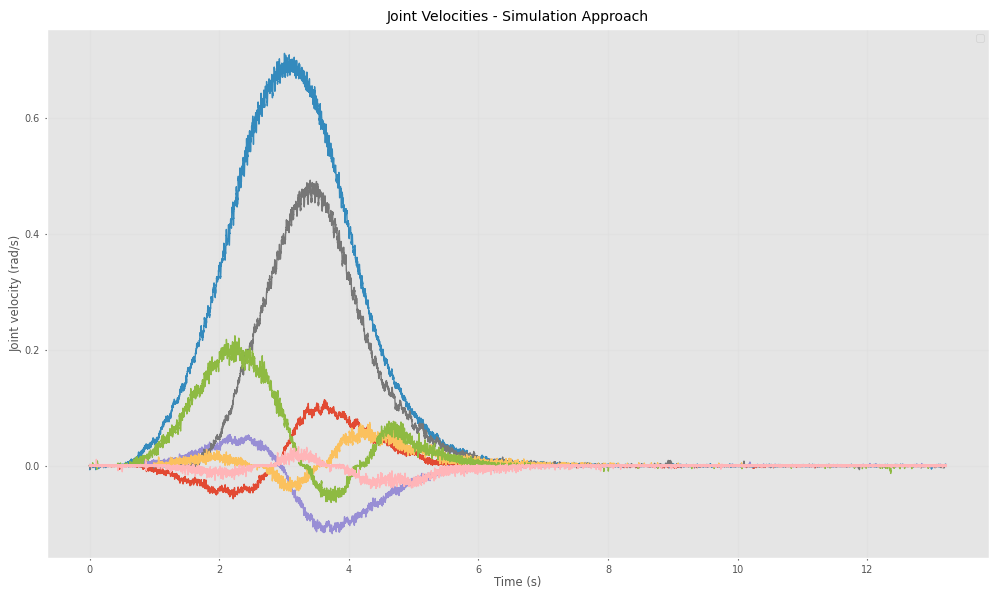

In [114]:

# Update visualization
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
adapter.step_simulation(adapter.dt)

log = panda_real.get_log()
# Plot trajectory
fig, ax = plt.subplots(figsize=(10, 6))
time_history = (log['time'] - log['time'][0])/1000
ax.plot(time_history, log['dq'],linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint velocity (rad/s)')
ax.set_title('Joint Velocities - Simulation Approach')
ax.legend(ncol=2)
# ax.set_ylim(-3, 3)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Case 2: Velocity Following - Manipulation Task

Generate twist trajectory for object manipulation and execute velocity commands.


In [ ]:
# Generate twist trajectory for manipulation
twist_trajectory = planner.generate_twist_trajectory(
    body_pose=grasp_pose,
    q=qs,
    s_axis=s_axes,
    theta=np.pi/2,  # 90 degree rotation
    h=0.0,          # no translation along screw axis
    theta_dot=0.1,  # angular velocity
    Tf=10.0,        # trajectory duration
    time_scaling='quintic',
    body_coordinate=True
)

print(f"Generated twist trajectory with {len(twist_trajectory)} points")

# Convert twists to joint velocity commands
velocity_commands = []
for twist in twist_trajectory:
    qd, _ = controller.compute_joint_velocities(twist=twist, optimization_type="j")
    velocity_commands.append(qd[:n])

print(f"Converted to {len(velocity_commands)} joint velocity commands")

# Execute velocity following in simulation
print("Starting manipulation in simulation...")

result_manip = executor.follow_velocities(
    velocity_commands=velocity_commands,
    sim_robot=panda_sim,
    use_real_robot=False
)

print(f"\nManipulation Results:")
print(f"  Steps: {result_manip.n_steps}")
print(f"  Execution time: {result_manip.execution_time:.2f}s")

# Save manipulation data
result_manip.save("manipulation_simulation.npz")
print("Manipulation data saved to 'manipulation_simulation.npz'")


## Execute Manipulation - Real Robot

Execute the manipulation task on the real robot.


In [ ]:
# Execute manipulation on real robot
print("⚠️  Real robot will perform manipulation - ensure object is grasped and workspace is clear!")

result_manip_real = executor.follow_velocities(
    velocity_commands=velocity_commands,
    sim_robot=panda_sim,
    real_robot=panda_real,
    use_real_robot=True  # 🔴 REAL ROBOT EXECUTION
)

print(f"\nReal Robot Manipulation Results:")
print(f"  Steps: {result_manip_real.n_steps}")
print(f"  Execution time: {result_manip_real.execution_time:.2f}s")

# Save real manipulation data
result_manip_real.save("manipulation_real.npz")
print("Real manipulation data saved to 'manipulation_real.npz'")
